In [80]:
import pandas as pd
import numpy as np
import pickle
import datatable as dt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score, median_absolute_error
import seaborn as sns



In [81]:
def read_feature_matrix() -> pd.DataFrame:
    feature_matrix = None
    with open('Preprocessed/feature_matrix_sparse.pkl', 'rb') as f:
        feature_matrix = pickle.load(f)
    
    feature_matrix = pd.DataFrame(feature_matrix.todense(),dtype="uint8")

    with open('Preprocessed/feature_matrix_columns.pkl', 'rb') as f:
        feature_matrix_columns = pickle.load(f)

    feature_matrix.columns = feature_matrix_columns
    return feature_matrix


In [82]:
pp_meals = pd.read_csv('Preprocessed/processed_meals.csv')
pp_interactions = pd.read_csv('Preprocessed/processed_interactions.csv')
feature_matrix = read_feature_matrix()
feature_matrix
# feature_matrix = pd.read_csv('Preprocessed/feature_matrix_with_titles.csv', dtype=np.uint8)
# feature_matrix


,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,broccolini,risoni,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178261,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178262,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
pp_interactions['user_id'].value_counts().sort_values(ascending=False).head(30)

94     6437
275    4581
193    3656
241    3465
208    3338
130    2851
564    2798
164    2733
319    2602
267    2457
100    2432
56     2377
260    2242
245    2232
345    2046
552    2024
82     2011
384    1987
141    1923
236    1839
377    1830
470    1817
736    1790
124    1758
108    1697
55     1679
453    1669
132    1667
243    1594
17     1592
Name: user_id, dtype: int64

In [84]:
user_id = pp_interactions['user_id'].value_counts().idxmax()
# user_id = 94
pp_interactions = pp_interactions.loc[pp_interactions['user_id'] == user_id].reset_index(drop=True)

In [85]:
rated_meals = feature_matrix.iloc[pp_interactions['recipe_id']]
# convert index to recipe_id in another column
rated_meals['recipe_id'] = feature_matrix.iloc[pp_interactions['recipe_id']].index
rated_meals = rated_meals.reset_index(drop=True)
# add rating column
rated_meals['rating'] = pp_interactions['rating']
rated_meals

C:\Users\hazem\AppData\Local\Temp\ipykernel_26676\13657870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_meals['recipe_id'] = feature_matrix.iloc[pp_interactions['recipe_id']].index


,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya,recipe_id,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4226,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,67852,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104194,4
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8498,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,151585,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,155019,5
6433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,135930,5
6434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,121145,5
6435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,114226,5


In [86]:
# split rated meals into train and test
train, validation = train_test_split(rated_meals, train_size=0.7, test_size=0.3, random_state=42)
# extract x_train, y_train, x_validation, y_validation by dropping recipe_id and rating columns
x_train = train.drop(['recipe_id', 'rating'], axis=1)
y_train = train['rating']
x_validation = validation.drop(['recipe_id', 'rating'], axis=1)
y_validation = validation['rating']

In [87]:
ONLINE = True

model = None
if ONLINE:
    model = SGDRegressor(learning_rate='constant', eta0=0.01, penalty='l1')
    # model = PassiveAggressiveRegressor(C=0.1, epsilon=0.01, tol=0.0001)
    for x, y in zip(x_train.values, y_train.values):
        model.partial_fit([x], [y])
else:
# train linear regression model
    model = GradientBoostingRegressor(
        n_estimators = 4780, 
        learning_rate = 0.01,
        max_depth = 10, 
        max_features = 'sqrt',
        min_samples_leaf = 1, 
        min_samples_split = 250, 
        loss = 'squared_error', 
        random_state = 6
    )
    model.fit(x_train, y_train)



In [88]:
y_pred = model.predict(x_validation)

rmse = mean_squared_error(y_validation, y_pred, squared=False)
r2 = r2_score(y_validation, y_pred)
explained_variance = explained_variance_score(y_validation, y_pred)

# misclassified examples after rounding the predictions
misclassified = (y_validation.to_numpy().astype(np.float64) != np.round(y_pred)).sum()
accuracy = 1 - (misclassified / len(y_validation))

print('RMSE: ', rmse)
print('R2: ', r2)
print('Explained Variance: ', explained_variance)
print('Misclassified: ', misclassified)
print('Accuracy: ', accuracy)


RMSE:  0.2502192100172809
R2:  -0.16443921976357734
Explained Variance:  -0.16053271043366335
Misclassified:  57
Accuracy:  0.9704968944099379


C:\Users\hazem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


In [89]:
# save model as pickle file
pickle.dump(model, open(f'Models/{user_id}_content_based_model.pkl', 'wb'))

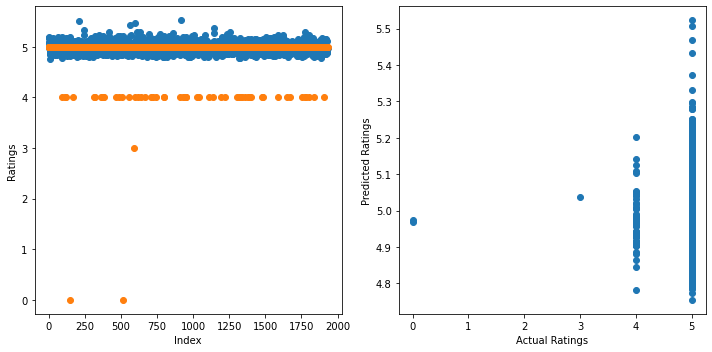

In [90]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x=range(y_pred.shape[0]), y=y_pred, label='Predicted Ratings')
plt.scatter(x=range(y_validation.shape[0]), y=y_validation, label='Actual Ratings')
plt.xlabel('Index')
plt.ylabel('Ratings')
plt.subplot(1, 2, 2)
plt.scatter(x=y_validation, y=y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.tight_layout()

---

Model use

In [91]:
unrated_meals = feature_matrix.iloc[~feature_matrix.index.isin(pp_interactions['recipe_id'])]
unrated_meals_ids = unrated_meals.index
unrated_meals

,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,broccolini,risoni,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178261,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178262,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
model = pickle.load(open(f'Models/{user_id}_content_based_model.pkl', 'rb'))

In [93]:
# convert csr_matrix to numpy array
# x_test = unrated_meals.toarray()
# add column names
# x_test = pd.DataFrame(x_test, columns=feature_matrix.columns)
x_test = unrated_meals
y_pred_test = model.predict(x_test)
y_pred_test

C:\Users\hazem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


array([4.94793282, 4.99768942, 5.19690607, ..., 5.23680111, 4.88210297,
       4.9907838 ])

In [94]:
y_pred_test.shape

(171828,)

In [95]:
# convert y_pred to be a tuple of y_pred and of recipe_id
unrated_lst = list(zip(y_pred_test, unrated_meals_ids))
unrated_lst.sort(key=lambda x: x[0], reverse=True)
unrated_lst

[(5.5205785004695, 72621),
 (5.507320147366756, 4325),
 (5.506645026602107, 52300),
 (5.485256931559393, 150667),
 (5.465646819630271, 139149),
 (5.457488295022118, 7225),
 (5.456967992112432, 167055),
 (5.454854771634516, 72693),
 (5.450860254191193, 131614),
 (5.446733603897504, 164389),
 (5.4444224162819905, 39477),
 (5.434394102304794, 160082),
 (5.432592284357462, 131963),
 (5.4319981972496345, 170076),
 (5.431228429388311, 89549),
 (5.430631001248327, 6746),
 (5.4279120660568045, 56365),
 (5.423113578114548, 31098),
 (5.418463260935899, 130126),
 (5.414790345303362, 159130),
 (5.4147696892872395, 26683),
 (5.412996817640429, 20949),
 (5.412340494893973, 93497),
 (5.412124179137544, 169157),
 (5.411537300504782, 115600),
 (5.410633010863844, 28768),
 (5.410471784758367, 9503),
 (5.410421881064254, 3121),
 (5.4096764478813615, 125176),
 (5.409549163039432, 35836),
 (5.409234136361997, 23531),
 (5.406704542880607, 65738),
 (5.4040328810323075, 79734),
 (5.402931169906216, 136543),
 

In [96]:
# get top 10 recommendations by mapping Ids to rows in pp_meals
top_10_recommendations = pp_meals.iloc[[x[1] for x in unrated_lst[:10]]]
top_10_recommendations

,id,calorie_level,replaced_ingredients,name,minutes,nutrition,steps,ingredients
72621,25498,1,"['vanilla ice cream', 'fresh blueberry', 'fres...",raspberry coconut and blueberry sundae,40,"[326.6, 13.0, 222.0, 3.0, 7.0, 26.0, 20.0]","['coconut sauce: in heavy saucepan , combine s...","['vanilla ice cream', 'fresh blueberries', 'fr..."
4325,472459,2,"['cajun seasoning', 'olive oil', 'chicken brea...",creamy cajun chicken pasta with bacon,40,"[1123.2, 89.0, 30.0, 23.0, 92.0, 157.0, 34.0]","['place chicken , olive oil and cajun seasonin...","['cajun seasoning', 'extra virgin olive oil', ..."
52300,203360,1,"['unsalted butter', 'olive oil', 'garlic', 'cr...",barefoot contessa s rosemary polenta,40,"[300.8, 32.0, 4.0, 11.0, 14.0, 51.0, 7.0]",['heat the butter and olive oil in a large sau...,"['unsalted butter', 'olive oil', 'garlic', 'cr..."
150667,77294,0,"['chicken wing', 'garlic', 'butter', 'olive oi...",deviled chicken wings,90,"[175.1, 20.0, 1.0, 4.0, 24.0, 19.0, 0.0]",['place wing pieces in a large ziploc plastic ...,"['chicken wings', 'garlic', 'butter', 'extra v..."
139149,283090,0,"['tortilla', 'cooking spray', 'avocado', 'key ...",southwest egg rolls made lighter,24,"[155.7, 11.0, 3.0, 9.0, 19.0, 16.0, 4.0]",['combine all dipping sauce ingredients in a b...,"['flour tortillas', 'non-fat cooking spray', '..."
7225,317873,1,"['whipped cream', 'strawberry preserve', 'mapl...",summertime fruit pancakes with fresh cream,35,"[252.8, 13.0, 34.0, 15.0, 17.0, 22.0, 12.0]",['for whipped cream: whip the heavy cream with...,"['whipped cream', 'strawberry preserves', 'red..."
167055,173134,2,"['vegetable oil', 'shallot', 'dry white wine',...",bbq shrimp blt sandwich,30,"[1351.8, 124.0, 17.0, 78.0, 72.0, 160.0, 38.0]","['make the sauce: in a medium saucepan , heat ...","['vegetable oil', 'shallots', 'dry white wine'..."
72693,210521,2,"['salmon', 'egg', 'cheddar', 'half-and-half', ...",unusual salmon loaf,40,"[506.7, 61.0, 18.0, 28.0, 37.0, 61.0, 6.0]","['mix the salmon , egg , cheese , half and hal...","['salmon', 'egg', 'cheddar cheese', 'half-and-..."
131614,52079,0,"['onion', 'red pepper', 'zucchini', 'jalapeno'...",sweet cornbread pudding with a kick,80,"[228.2, 22.0, 11.0, 21.0, 14.0, 40.0, 6.0]","['heat oven to 350 degrees', 'cook onions , pe...","['onion', 'red pepper', 'zucchini', 'jalapeno'..."
164389,503146,2,"['cooked chicken', 'sweet onion', 'fresh parsl...",the moroccan pita sandwich zwt 9,15,"[856.1, 62.0, 83.0, 32.0, 112.0, 36.0, 23.0]","['in a med-sized bowl , combine chicken w / on...","['cooked chicken', 'sweet onion', 'fresh parsl..."
